### LSTM Code Credited to: https://www.kaggle.com/taronzakaryan/stock-prediction-lstm-using-pytorch

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import math
from sklearn.metrics import mean_squared_error
from datetime import datetime

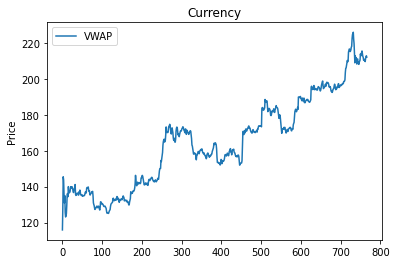

In [2]:
def convert_date(dt):
    return datetime.strptime(dt, '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%d-%H')

def convert_date_2(dt):
    return datetime.strptime(dt, '%Y-%m-%d-%H').strftime('%Y-%m-%dT%H:%M:%SZ')

epoch_0 = datetime(1970,1,1,0,0,0)

def convertDate(date):
    return (pd.Timestamp(date) - epoch_0) / (np.timedelta64(1,'s'))

df = pd.read_csv("./BTC-2h-new.csv")
df['created_at'] = df['created_at'].apply(convertDate)
df['modified'] = df['modified'].apply(convertDate)
df['Date'] = df['Date'].apply(convertDate)
df = df.sort_values(by=['created_at'])
df = df.fillna(method='ffill')
df = df.fillna(0)
df = df[df.Symbol == 3].reset_index()
df = df.drop_duplicates()

df[['VWAP']].plot()
plt.ylabel("Price")
plt.title("Currency")
plt.show()

In [3]:
df

,index,created_at,sum_interaction_count,sum_weighted_sentiment,positive_count,negative_count,null_count,volume_tweets,overall_sentiment,modified,Date,Symbol,Volume,VWAP,AdrActCnt,BlkCnt,BlkSizeMeanByte,CapMrktCurUSD,DiffMean,FeeTotUSD,HashRate,ROI1yr,ROI30d,SplyCur,TxCnt,TxTfrValAdjUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d
0,884,1.584536e+09,0,0,0,0,1,1,0.0,1.584544e+09,1.584544e+09,3,1107.983835,115.920000,445445,6509,24937.493931,1.297253e+10,2.133805e+15,89463.705092,160.756648,-14.066321,-54.894476,1.101388e+08,763100,4.286378e+08,0.061491,0.122326,0.092231
1,885,1.584623e+09,0,0,0,0,2,2,2.0,1.584630e+09,1.584630e+09,3,1126.129190,127.918333,434714,6531,24088.277140,1.296312e+10,2.180507e+15,72228.732404,164.887652,-14.677746,-55.859074,1.101525e+08,768437,3.309421e+08,0.061479,0.122101,0.092153
2,887,1.584698e+09,0,0,0,0,1,1,2.0,1.584706e+09,1.584706e+09,3,2338.132523,145.498333,465615,6482,27412.984264,1.513215e+10,2.190931e+15,121996.009058,164.390857,-0.957840,-51.560486,1.101662e+08,864017,5.575151e+08,0.062596,0.125564,0.094293
3,888,1.584709e+09,0,0,0,0,2,2,2.0,1.584716e+09,1.584716e+09,3,1151.757464,143.746667,465615,6482,27412.984264,1.513215e+10,2.190931e+15,121996.009058,164.390857,-0.957840,-51.560486,1.101662e+08,864017,5.575151e+08,0.062596,0.125564,0.094293
4,886,1.584720e+09,6,12,2,0,0,2,2.0,1.584727e+09,1.584727e+09,3,8347.853618,136.140000,465615,6482,27412.984264,1.513215e+10,2.190931e+15,121996.009058,164.390857,-0.957840,-51.560486,1.101662e+08,864017,5.575151e+08,0.062596,0.125564,0.094293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,1645,1.588356e+09,534,1068,30,0,9,39,2.0,1.588363e+09,1.588363e+09,3,271.178541,209.623333,417656,6377,28663.151952,2.291023e+10,2.276654e+15,263995.466102,168.111771,30.755357,54.960496,1.107391e+08,899459,6.745149e+08,0.064043,0.052569,0.097623
763,1633,1.588360e+09,126,252,36,0,0,36,2.0,1.588367e+09,1.588367e+09,3,756.143044,211.311667,417656,6377,28663.151952,2.291023e+10,2.276654e+15,263995.466102,168.111771,30.755357,54.960496,1.107391e+08,899459,6.745149e+08,0.064043,0.052569,0.097623
764,1648,1.588363e+09,9,18,9,0,0,9,2.0,1.588370e+09,1.588370e+09,3,696.534122,212.330000,417656,6377,28663.151952,2.291023e+10,2.276654e+15,263995.466102,168.111771,30.755357,54.960496,1.107391e+08,899459,6.745149e+08,0.064043,0.052569,0.097623
765,1637,1.588367e+09,20,20,0,10,0,10,1.0,1.588374e+09,1.588374e+09,3,460.584272,212.860000,417656,6377,28663.151952,2.291023e+10,2.276654e+15,263995.466102,168.111771,30.755357,54.960496,1.107391e+08,899459,6.745149e+08,0.064043,0.052569,0.097623


In [4]:
df.columns

Index(['index', 'created_at', 'sum_interaction_count',
       'sum_weighted_sentiment', 'positive_count', 'negative_count',
       'null_count', 'volume_tweets', 'overall_sentiment', 'modified', 'Date',
       'Symbol', 'Volume', 'VWAP', 'AdrActCnt', 'BlkCnt', 'BlkSizeMeanByte',
       'CapMrktCurUSD', 'DiffMean', 'FeeTotUSD', 'HashRate', 'ROI1yr',
       'ROI30d', 'SplyCur', 'TxCnt', 'TxTfrValAdjUSD', 'VtyDayRet180d',
       'VtyDayRet30d', 'VtyDayRet60d'],
      dtype='object')

In [5]:
#df = df[['VWAP', 'positive_count', 'negative_count', 'null_count', 'Volume', 'volume_tweets', 'AdrActCnt', 'BlkCnt', 'BlkSizeMeanByte', 'CapMrktCurUSD', 'DiffMean','FeeTotUSD', 'HashRate', 'ROI1yr', 'ROI30d', 'SplyCur', 'TxCnt','TxTfrValAdjUSD', 'VtyDayRet180d', 'VtyDayRet30d', 'VtyDayRet60d']]
#df = df.drop(['index', 'created_at', 'Date', 'Symbol', 'modified'], axis=1)
#df = df[['VWAP']]
df

,index,created_at,sum_interaction_count,sum_weighted_sentiment,positive_count,negative_count,null_count,volume_tweets,overall_sentiment,modified,Date,Symbol,Volume,VWAP,AdrActCnt,BlkCnt,BlkSizeMeanByte,CapMrktCurUSD,DiffMean,FeeTotUSD,HashRate,ROI1yr,ROI30d,SplyCur,TxCnt,TxTfrValAdjUSD,VtyDayRet180d,VtyDayRet30d,VtyDayRet60d
0,884,1.584536e+09,0,0,0,0,1,1,0.0,1.584544e+09,1.584544e+09,3,1107.983835,115.920000,445445,6509,24937.493931,1.297253e+10,2.133805e+15,89463.705092,160.756648,-14.066321,-54.894476,1.101388e+08,763100,4.286378e+08,0.061491,0.122326,0.092231
1,885,1.584623e+09,0,0,0,0,2,2,2.0,1.584630e+09,1.584630e+09,3,1126.129190,127.918333,434714,6531,24088.277140,1.296312e+10,2.180507e+15,72228.732404,164.887652,-14.677746,-55.859074,1.101525e+08,768437,3.309421e+08,0.061479,0.122101,0.092153
2,887,1.584698e+09,0,0,0,0,1,1,2.0,1.584706e+09,1.584706e+09,3,2338.132523,145.498333,465615,6482,27412.984264,1.513215e+10,2.190931e+15,121996.009058,164.390857,-0.957840,-51.560486,1.101662e+08,864017,5.575151e+08,0.062596,0.125564,0.094293
3,888,1.584709e+09,0,0,0,0,2,2,2.0,1.584716e+09,1.584716e+09,3,1151.757464,143.746667,465615,6482,27412.984264,1.513215e+10,2.190931e+15,121996.009058,164.390857,-0.957840,-51.560486,1.101662e+08,864017,5.575151e+08,0.062596,0.125564,0.094293
4,886,1.584720e+09,6,12,2,0,0,2,2.0,1.584727e+09,1.584727e+09,3,8347.853618,136.140000,465615,6482,27412.984264,1.513215e+10,2.190931e+15,121996.009058,164.390857,-0.957840,-51.560486,1.101662e+08,864017,5.575151e+08,0.062596,0.125564,0.094293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,1645,1.588356e+09,534,1068,30,0,9,39,2.0,1.588363e+09,1.588363e+09,3,271.178541,209.623333,417656,6377,28663.151952,2.291023e+10,2.276654e+15,263995.466102,168.111771,30.755357,54.960496,1.107391e+08,899459,6.745149e+08,0.064043,0.052569,0.097623
763,1633,1.588360e+09,126,252,36,0,0,36,2.0,1.588367e+09,1.588367e+09,3,756.143044,211.311667,417656,6377,28663.151952,2.291023e+10,2.276654e+15,263995.466102,168.111771,30.755357,54.960496,1.107391e+08,899459,6.745149e+08,0.064043,0.052569,0.097623
764,1648,1.588363e+09,9,18,9,0,0,9,2.0,1.588370e+09,1.588370e+09,3,696.534122,212.330000,417656,6377,28663.151952,2.291023e+10,2.276654e+15,263995.466102,168.111771,30.755357,54.960496,1.107391e+08,899459,6.745149e+08,0.064043,0.052569,0.097623
765,1637,1.588367e+09,20,20,0,10,0,10,1.0,1.588374e+09,1.588374e+09,3,460.584272,212.860000,417656,6377,28663.151952,2.291023e+10,2.276654e+15,263995.466102,168.111771,30.755357,54.960496,1.107391e+08,899459,6.745149e+08,0.064043,0.052569,0.097623


In [0]:
index_vwap = list(df.columns).index('VWAP')

In [0]:
df = df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
df = scaler.fit_transform(df)

In [8]:
def load_data(stock, look_back):
    data_raw = stock
    data = []
    
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1, index_vwap:index_vwap+1]
    
    x_test = data[train_set_size:,:-1, :]
    y_test = data[train_set_size:,-1,index_vwap:index_vwap+1]
    
    return [x_train, y_train, x_test, y_test]

look_back = 32 # how much to look back in each step

x_train, y_train, x_test, y_test = load_data(df, look_back)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(588, 31, 29)
(588, 1)
(147, 31, 29)
(147, 1)


In [9]:
x_train.shape

(588, 31, 29)

In [0]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [11]:
y_train.size(),x_train.size()

(torch.Size([588, 1]), torch.Size([588, 31, 29]))

In [0]:
n_steps = look_back - 1
batch_size = 100
num_epochs = 400

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [13]:
input_dim = x_train.shape[-1]
hidden_dim = 25
num_layers = 2
output_dim = 1

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h.detach(), c.detach())) 
        out = self.fc(out[:, -1, :]) 
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(29, 25, num_layers=2, batch_first=True)
  (fc): Linear(in_features=25, out_features=1, bias=True)
)
10
torch.Size([100, 29])
torch.Size([100, 25])
torch.Size([100])
torch.Size([100])
torch.Size([100, 25])
torch.Size([100, 25])
torch.Size([100])
torch.Size([100])
torch.Size([1, 25])
torch.Size([1])


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [14]:
hist = np.zeros(num_epochs)
seq_dim =look_back-1  

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch  10 MSE:  0.08796504139900208
Epoch  20 MSE:  0.013059969060122967
Epoch  30 MSE:  0.00908153597265482
Epoch  40 MSE:  0.007603777572512627
Epoch  50 MSE:  0.0045652627013623714
Epoch  60 MSE:  0.003407486481592059
Epoch  70 MSE:  0.002711885841563344
Epoch  80 MSE:  0.0024918923154473305
Epoch  90 MSE:  0.0022928016260266304
Epoch  100 MSE:  0.002142388606444001
Epoch  110 MSE:  0.002029629424214363
Epoch  120 MSE:  0.0019435002468526363
Epoch  130 MSE:  0.0018754064803943038
Epoch  140 MSE:  0.0018278174102306366
Epoch  150 MSE:  0.001969017321243882
Epoch  160 MSE:  0.0018458185950294137
Epoch  170 MSE:  0.0018769354792311788
Epoch  180 MSE:  0.0018536349525675178
Epoch  190 MSE:  0.001961776986718178
Epoch  200 MSE:  0.0016277626855298877
Epoch  210 MSE:  0.0021039836574345827
Epoch  220 MSE:  0.0019103572703897953
Epoch  230 MSE:  0.0014805946266278625
Epoch  240 MSE:  0.001311929663643241
Epoch  250 MSE:  0.0014030899619683623
Epoch  260 MSE:  0.0018914503743872046
Epoch  2

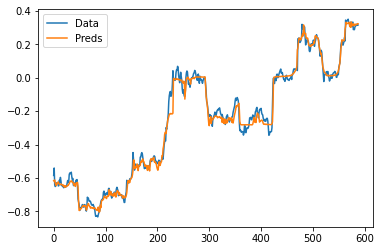

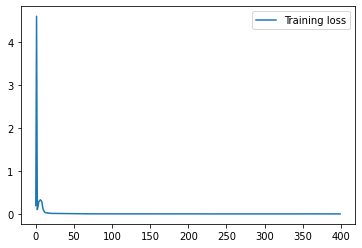

In [15]:
plt.plot(y_train.detach().numpy(), label="Data")
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [0]:
scaler2 = MinMaxScaler()
scaler2.min_, scaler2.scale_ = scaler.min_[index_vwap], scaler.scale_[index_vwap]

In [17]:
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler2.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler2.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler2.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler2.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.89 RMSE
Test Score: 12.36 RMSE


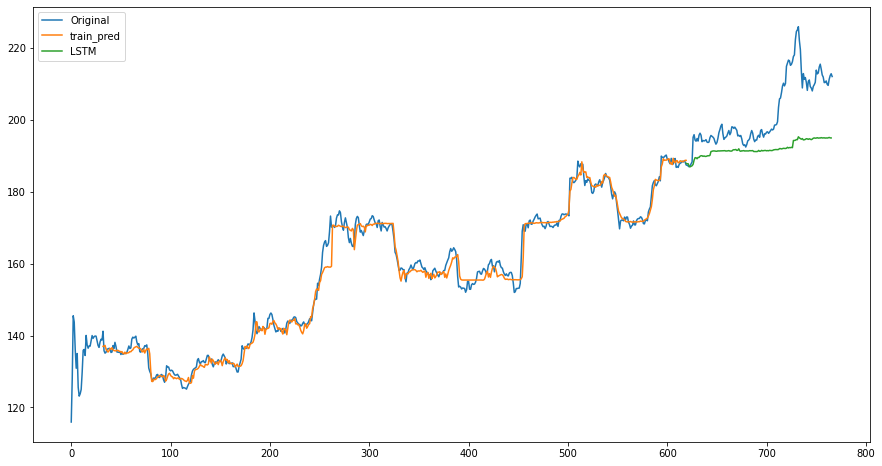

In [18]:
trainPredictPlot = np.empty_like(df[:,index_vwap:index_vwap+1])
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred

testPredictPlot = np.empty_like(df[:,index_vwap:index_vwap+1])
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+look_back-1:len(df)-1, :] = y_test_pred

regPredictPLot = np.empty_like(df[:,index_vwap:index_vwap+1])
regPredictPLot[:, :] = np.nan
#regPredictPLot[len(df)-len(y_predict):, :] = y_predict

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(df)[:,index_vwap], label='Original')
plt.plot(trainPredictPlot, label='train_pred')
plt.plot(testPredictPlot, label='LSTM')
#plt.plot(regPredictPLot, label='Regression')
plt.legend()
plt.show()

In [0]:
import datetime
import numpy as np
epoch_0 = datetime.datetime(1970,1,1,0,0,0)

def convertDate(date):
    return (pd.Timestamp(date) - epoch_0) / (np.timedelta64(1,'s'))

K_LIST = [2, 5, 12, 24, 48]
SYMBOLS_LIST = ['BTC.X', 'BCH.X', 'LTC.X', 'ETH.X']

twoHdata = pd.read_csv("2h.csv") 
fiveH_data = pd.read_csv("5h.csv") 
twelveH_data = pd.read_csv("12h.csv") 
twoFourH_data = pd.read_csv("24h.csv") 
fourEight_data = pd.read_csv("48h.csv") 

hour_df_list = [twoHdata, fiveH_data, twelveH_data, twoFourH_data, fourEight_data]
hour_symbol_df_list = []

for k_index in range(len(K_LIST)):
    df = hour_df_list[k_index]
    df['created_at'] = df['created_at'].apply(convertDate)
    df['modified'] = df['modified'].apply(convertDate)
    df['Date'] = df['Date'].apply(convertDate)
    df = df.sort_values(by=['created_at'])
    df = df.fillna(method='ffill')
    df = df.fillna(0)
    hour_symbol_list = []
    for symbol_index in range(len(SYMBOLS_LIST)):
        df_symbol = df[df.Symbol == symbol_index].reset_index()
        hour_symbol_list.append(df_symbol)
    
    hour_symbol_df_list.append(hour_symbol_list)

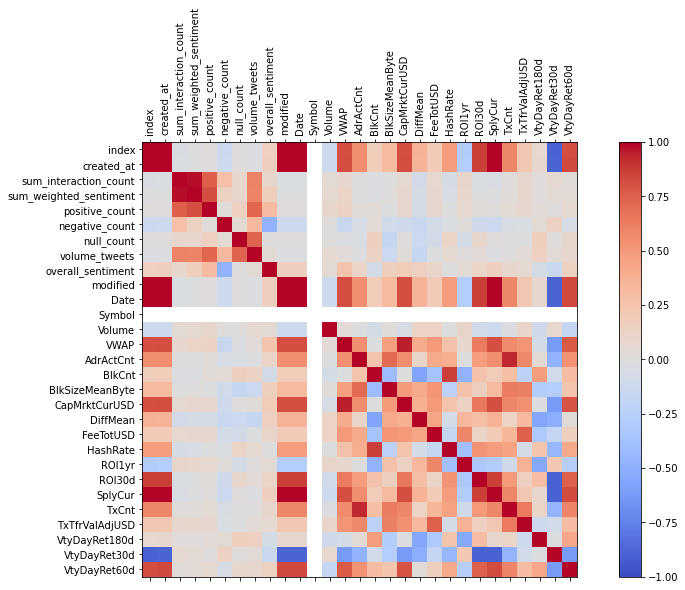

In [20]:
data = hour_symbol_df_list[0][0]
corr = data.corr()
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

In [0]:
from sklearn.model_selection import train_test_split

X_train_hour_symbol = []
y_train_hour_symbol = []
X_test_hour_symbol = []
y_test_hour_symbol = []

for k_index in range(len(K_LIST)):
    X_train_hour_symbol_list = []
    y_train_hour_symbol_list = []
    X_test_hour_symbol_list = []
    y_test_hour_symbol_list = []
    
    for symbol_index in range(len(SYMBOLS_LIST)):
        df = hour_symbol_df_list[k_index][symbol_index]
        X = df.drop('VWAP', axis = 1)
        y = df[['VWAP']]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)
        
        X_train_hour_symbol_list.append(X_train)
        y_train_hour_symbol_list.append(y_train)
        X_test_hour_symbol_list.append(X_test)
        y_test_hour_symbol_list.append(y_test)
    
    X_train_hour_symbol.append(X_train_hour_symbol_list)
    y_train_hour_symbol.append(y_train_hour_symbol_list)
    X_test_hour_symbol.append(X_test_hour_symbol_list)
    y_test_hour_symbol.append(y_test_hour_symbol_list)

In [22]:
X_train_hour_symbol[0][0].shape

(707, 28)

In [0]:
from sklearn.linear_model import LinearRegression

reg_model_hour_symbol = []

for k_index in range(len(K_LIST)):
    reg_model_hour_symbol_list = []
    for symbol_index in range(len(SYMBOLS_LIST)):
        regression_model = LinearRegression()
        regression_model.fit(X_train_hour_symbol[k_index][symbol_index], y_train_hour_symbol[k_index][symbol_index])
        regression_model.score(X_test_hour_symbol[k_index][symbol_index], y_test_hour_symbol[k_index][symbol_index])
        reg_model_hour_symbol_list.append(regression_model)
        
    reg_model_hour_symbol.append(reg_model_hour_symbol_list)

In [24]:
from sklearn.metrics import mean_squared_error
import math

total_r_squared = []
total_r_squared_sum = 0

for k_index in range(len(K_LIST)):
    for symbol_index in range(len(SYMBOLS_LIST)):
        regression_model = reg_model_hour_symbol[k_index][symbol_index]
        X_test = X_test_hour_symbol[k_index][symbol_index]
        X_train = X_train_hour_symbol[k_index][symbol_index]
        y_test = y_test_hour_symbol[k_index][symbol_index]
        y_train = y_train_hour_symbol[k_index][symbol_index]
        
        rSquared = regression_model.score(X_test, y_test)
        y_predict = regression_model.predict(X_test)
        regression_model_mse = mean_squared_error(y_predict, y_test)
        RMSE = math.sqrt(regression_model_mse)
        total_r_squared.append(rSquared)
        total_r_squared_sum = total_r_squared_sum + rSquared
        # plot
        print("R2 for", K_LIST[k_index], "h-", SYMBOLS_LIST[symbol_index], ":", rSquared)
        print("RMSE for", K_LIST[k_index], "h-", SYMBOLS_LIST[symbol_index], ":", RMSE, "\n")

print(total_r_squared_sum)
print((total_r_squared_sum)/20)
print(np.var(total_r_squared))

R2 for 2 h- BTC.X : 0.328530599472202
RMSE for 2 h- BTC.X : 455.0771190515844 

R2 for 2 h- BCH.X : -17.735475115603965
RMSE for 2 h- BCH.X : 25.194075299979172 

R2 for 2 h- LTC.X : -0.3388882942089684
RMSE for 2 h- LTC.X : 2.112329359633918 

R2 for 2 h- ETH.X : -0.8136335016509573
RMSE for 2 h- ETH.X : 12.823540385025577 

R2 for 5 h- BTC.X : 0.22433684161522205
RMSE for 5 h- BTC.X : 484.6447541069282 

R2 for 5 h- BCH.X : -3.767976052082192
RMSE for 5 h- BCH.X : 13.280083686649242 

R2 for 5 h- LTC.X : -0.35109697082082136
RMSE for 5 h- LTC.X : 2.0956067876031326 

R2 for 5 h- ETH.X : -1.112043573906159
RMSE for 5 h- ETH.X : 13.786151278764846 

R2 for 12 h- BTC.X : -0.13288831502970888
RMSE for 12 h- BTC.X : 586.8921185420423 

R2 for 12 h- BCH.X : -0.06866414023736378
RMSE for 12 h- BCH.X : 6.858929128039634 

R2 for 12 h- LTC.X : -0.4142836232770757
RMSE for 12 h- LTC.X : 2.065996010498688 

R2 for 12 h- ETH.X : -1.4394774786937568
RMSE for 12 h- ETH.X : 14.324185749012877 

R2 

In [25]:
len(list(regression_model.coef_[0]))

28

In [0]:
coefs = {c:list(regression_model.coef_[0])[i] for i, c in enumerate(X.columns)}

In [27]:
sorted(coefs.items(), key=lambda x: x[1])

[('HashRate', -2.234626646231968),
 ('ROI1yr', -0.6237437432873777),
 ('VtyDayRet30d', -0.1025321125637131),
 ('positive_count', -0.03236679351855298),
 ('volume_tweets', -0.014864136047647044),
 ('sum_interaction_count', -0.010410013493413034),
 ('VtyDayRet60d', -0.007488943722129271),
 ('created_at', -0.004818220368609622),
 ('null_count', -0.00306518358354917),
 ('BlkSizeMeanByte', -0.0028542800451169903),
 ('SplyCur', -0.00018683281917782237),
 ('AdrActCnt', -4.139333373911814e-05),
 ('Symbol', -2.5461403818649586e-13),
 ('DiffMean', 1.5165299571684443e-13),
 ('CapMrktCurUSD', 7.72406121485113e-09),
 ('TxTfrValAdjUSD', 1.2944481377978696e-08),
 ('FeeTotUSD', 6.361532181468699e-05),
 ('TxCnt', 7.443675261098568e-05),
 ('Volume', 0.0008457608663796743),
 ('VtyDayRet180d', 0.002163062660775531),
 ('Date', 0.002419577475474158),
 ('modified', 0.002419577475937225),
 ('sum_weighted_sentiment', 0.007727185877756064),
 ('negative_count', 0.02056784111432896),
 ('BlkCnt', 0.025759746282263